In [8]:
import os

os.getcwd()

'/home/won/miniconda3/envs/hailocp/lib/python3.10/site-packages/hailo_tutorials/notebooks'

# Parsing Tutorial

## Hailo Parsing Examples from TensorFlow/Pytorch to HAR

This tutorial describes the steps for parsing models from various frameworks to the HAR format (Hailo Archive).  
HAR is a tar.gz archive file that contains the representation of the graph structure and the weights that are deployed to Hailo's runtime.

Note:
**Running this code in Jupyter notebook is recommended**, see the Introduction tutorial for more details.

Note:
This section demonstrates the Python APIs for Hailo Parser.
You could also use the CLI: try `hailo parser {tf, onnx} --help`.  
More details on Dataflow Compiler User Guide / Building Models / Profiler and other command line tools.

In [4]:
# General imports used throughout the tutorial
import tensorflow as tf
from IPython.display import SVG

# import the ClientRunner class from the hailo_sdk_client package
from hailo_sdk_client import ClientRunner

Set the hardware architecture to be used throughout the tutorial:

In [5]:
chosen_hw_arch = "hailo8"
# For Mini PCIe modules or Hailo-8R devices, use 'hailo8r'

## Parsing Example from ONNX to HAR

Choose the ONNX file to be used throughout the example:

In [6]:
onnx_model_name = "resnet_v1_18"
onnx_path = "../models/resnet_v1_18.onnx"

The main API of the Dataflow Compiler that the user interacts with is the ClientRunner class (see the API Reference section on the Dataflow Compiler user guide for more information).  

Initialize a ClientRunner and use the translate_onnx_model method. 

Arguments:

* model_path
* model_name to use
* start_node_names (list of str, optional): Name of the first ONNX node to parse.
* end_node_names (list of str, optional): List of ONNX nodes, that the parsing can stop after all of them are parsed.
* net_input_shapes (dict, optional): A dictionary describing the input shapes for each of the start nodes given in start_node_names, where the keys are the names of the start nodes and the values are their corresponding input shapes. Use only when the original model has dynamic input shapes (described with a wildcard
denoting each dynamic axis, e.g. [b, c, h, w]). 

As a suggestion try translating the ONNX model without supplying the optional arguments.

In [7]:
runner = ClientRunner(hw_arch=chosen_hw_arch)
hn, npz = runner.translate_onnx_model(
    onnx_path,
    onnx_model_name,
    start_node_names=["input.1"],
    end_node_names=["192"],
    net_input_shapes={"input.1": [1, 3, 224, 224]},
)

[info] Translation started on ONNX model resnet_v1_18
[info] Restored ONNX model resnet_v1_18 (completion time: 00:00:00.11)
[info] Extracted ONNXRuntime meta-data for Hailo model (completion time: 00:00:00.35)
[info] Start nodes mapped from original model: 'input.1': 'resnet_v1_18/input_layer1'.
[info] End nodes mapped from original model: '/softmax/Softmax'.
[info] Translation completed on ONNX model resnet_v1_18 (completion time: 00:00:00.45)


## Hailo Archive

Hailo Archive is a tar.gz archive file that captures the "state" of the model - the files and attributes used in a given stage from parsing to compilation.
Use the `save_har` method to save the runner's state in any stage and `load_har` method to load a saved state to an uninitialized runner.

The initial HAR file includes:
- HN file, which is a JSON-like representation of the graph structure that is deployed to the Hailo hardware.
- NPZ file, which includes the weights of the model.

Save the parsed model in a Hailo Archive file:

In [9]:
hailo_model_har_name = f"{onnx_model_name}_hailo_model.har"
runner.save_har(hailo_model_har_name)

[info] Saved HAR to: /home/won/miniconda3/envs/hailocp/lib/python3.10/site-packages/hailo_tutorials/notebooks/resnet_v1_18_hailo_model.har


Visualize the graph with Hailo’s visualizer tool:

[info] Current Time: 10:23:27, 09/26/25
[info] CPU: Architecture: x86_64, Model: 13th Gen Intel(R) Core(TM) i7-13700K, Number Of Cores: 24, Utilization: 1.1%
[info] Memory: Total: 31GB, Available: 24GB
[info] System info: OS: Linux, Kernel: 6.14.0-29-generic
[info] Hailo DFC Version: 3.33.0
[info] HailoRT Version: Not Installed
[info] PCIe: No Hailo PCIe device was found
[info] Running `hailo visualizer resnet_v1_18_hailo_model.har --no-browser`
[info] Visualized network saved to: /home/won/miniconda3/envs/hailocp/lib/python3.10/site-packages/hailo_tutorials/notebooks/resnet_v1_18.svg


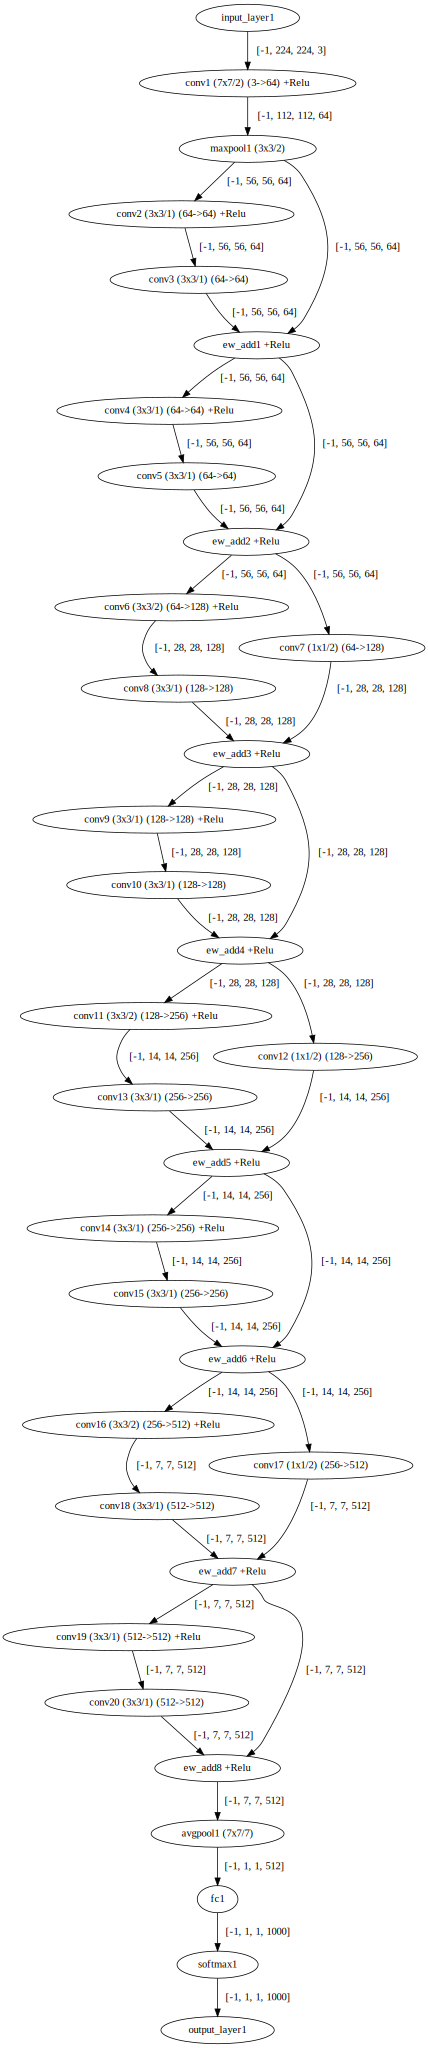

In [10]:
!hailo visualizer {hailo_model_har_name} --no-browser
SVG("resnet_v1_18.svg")

## Parsing Example from TensorFlow Lite
The Hailo parser supports inference models as inputs, therefore we advise to use TensorFlow Lite representation for TensorFlow 2 models (TF2 SavedModel format is commonly used for training models).  

Parsing the TensorFlow Lite format is similar to parsing ONNX models.  
The parser identifies the input format automatically.

The following example shows how to parse a TensorFlow Lite model, using a different model.

In [11]:
model_name = "dense_example"
model_path = "../models/v3-large-minimalistic_224_1.0_float.tflite"

runner = ClientRunner(hw_arch=chosen_hw_arch)
hn, npz = runner.translate_tf_model(model_path, model_name)

[info] Translation started on Tensorflow model dense_example
[info] Start nodes mapped from original model: 'input': 'dense_example/input_layer1'.
[info] End nodes mapped from original model: 'MobilenetV3/Predictions/Softmax'.
[info] Translation completed on Tensorflow model dense_example (completion time: 00:00:00.15)


## Common Conversion Methods from Tensorflow to Tensorflow Lite
The following examples focus on Tensorflow's TFLite converter support for various TF formats, showing
how older formats of TF can be converted to TFLite, which can then be used in Hailo's parsing stage.

In [14]:
# Build a simple Keras model and convert it to tflite
def build_small_example_net():
    inputs = tf.keras.Input(shape=(24, 24, 96), name="img")
    x = tf.keras.layers.Conv2D(24, 1, name="conv1")(inputs)
    x = tf.keras.layers.BatchNormalization(momentum=0.9, name="bn1")(x)
    outputs = tf.keras.layers.ReLU(max_value=6.0, name="relu1")(x)
    model = tf.keras.Model(inputs, outputs, name="small_example_net")
    return model


# Converting the Model to tflite
model = build_small_example_net()
model_name = "small_example"
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS,  # enable TensorFlow ops.
]
tflite_model = converter.convert()  # may cause warnings in jupyter notebook, don't worry.
tflite_model_path = "../models/small_example.tflite"
with tf.io.gfile.GFile(tflite_model_path, "wb") as f:
    f.write(tflite_model)

# Parsing the model to Hailo format
runner = ClientRunner(hw_arch=chosen_hw_arch)
hn, npz = runner.translate_tf_model(tflite_model_path, model_name)

Saved artifact at '/tmp/tmpgkar1spi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 24, 24, 96), dtype=tf.float32, name='img')
Output Type:
  TensorSpec(shape=(None, 24, 24, 24), dtype=tf.float32, name=None)
Captures:
  138456313409808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138456312356832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138456312355072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138456312362816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138456312360352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138456312360528: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1758850060.203594    9416 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1758850060.203603    9416 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


[info] Translation started on Tensorflow model small_example
[info] Start nodes mapped from original model: 'serving_default_img:0': 'small_example/input_layer1'.
[info] End nodes mapped from original model: 'StatefulPartitionedCall_1:0'.
[info] Translation completed on Tensorflow model small_example (completion time: 00:00:00.01)


In [16]:
# Alternatively, convert an already saved TF2.x SavedModel to tflite
model_path = "../models/dense_example_tf2/"
model_name = "dense_example_tf2"
converter = tf.lite.TFLiteConverter.from_saved_model(model_path)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS,  # enable TensorFlow ops.
]
tflite_model = converter.convert()  # may cause warnings in jupyter notebook, don't worry.
tflite_model_path = "../models/dense_example_tf2.tflite"
with tf.io.gfile.GFile(tflite_model_path, "wb") as f:
    f.write(tflite_model)

# Parsing the model to Hailo format
runner = ClientRunner(hw_arch=chosen_hw_arch)
hn, npz = runner.translate_tf_model(tflite_model_path, model_name)

hailo_model_har_name = f"{model_name}_hailo_model.har"
runner.save_har(hailo_model_har_name)

W0000 00:00:1758850190.599701    9416 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1758850190.599712    9416 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


[info] Translation started on Tensorflow model dense_example_tf2
[info] Start nodes mapped from original model: 'serving_default_img:0': 'dense_example_tf2/input_layer1'.
[info] End nodes mapped from original model: 'StatefulPartitionedCall:0'.
[info] Translation completed on Tensorflow model dense_example_tf2 (completion time: 00:00:00.01)
[info] Saved HAR to: /home/won/miniconda3/envs/hailocp/lib/python3.10/site-packages/hailo_tutorials/notebooks/dense_example_tf2_hailo_model.har
